# Auto Encoders and VAEs

In this notebook we will:

1. Load MNIST digits and add some noise
2. Train an autoencoder to denoise the images
3. Train a Variational Autoencoder (VAE) to generate new images

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

## Load digits
We first define some helper functions to load the MNIST digits and add some noise to them.

In [126]:
DATA_PATH = '../data/'

In [55]:
class MNISTDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        target = image.clone()
        # onehot labels
        labels = np.zeros(10)
        labels[label] = 1
        
        return image, target, torch.tensor(labels, dtype=torch.float32)
    
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())

train_dataset = MNISTDataset(train_dataset)
test_dataset = MNISTDataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

We make a custom dataset and a function to add noise to the digits

In [56]:
def add_noise(x, noise_factor):
    noisy_x =  (1-noise_factor)*x + noise_factor * torch.randn(x.size())
    return noisy_x

Plot some digits with added noise to see what they look like.

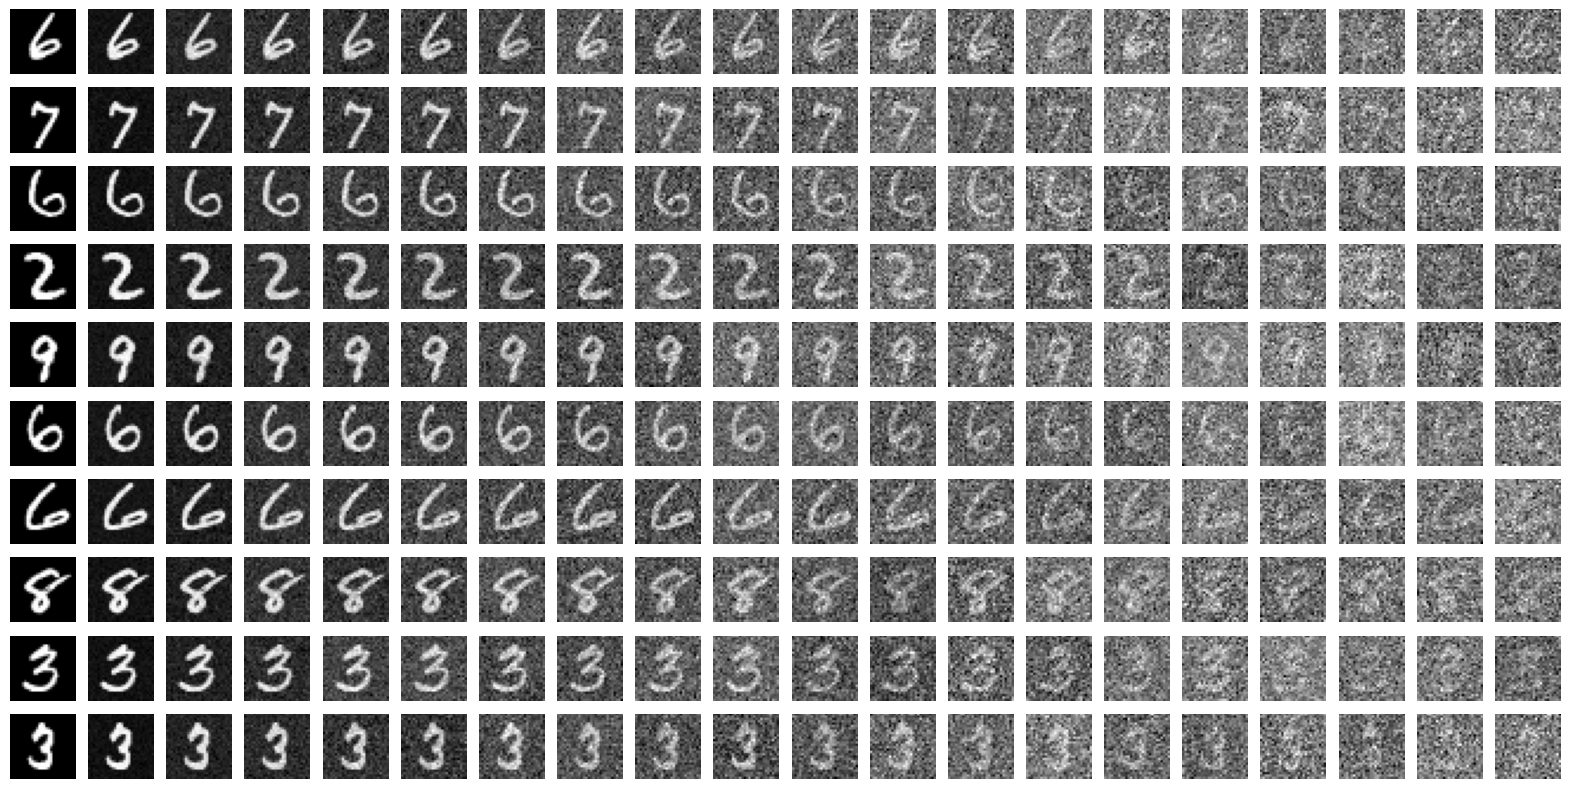

In [63]:
sample_x = next(iter(train_loader))[0]
sample_x = sample_x[:10]

eps = np.linspace(0, 0.5, 20)

fig, axs = plt.subplots(10, 20, figsize=(20, 10))
for i in range(10):
    for j in range(20):
        axs[i, j].imshow(add_noise(sample_x[i], eps[j]).squeeze(), cmap='gray')
        axs[i, j].axis('off')

## Auto Encoder
This is a really simple auto encoder. It's simple because it is entirely composed of linear layers. We reduce dimensionality of the data from 784 dimensions down to only 8!

In [64]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 8),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28*28),
            torch.nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Training

In [66]:
img, _, _ = next(iter(train_loader))
model = Autoencoder()

noisy_img = add_noise(img, 0.5)
print(noisy_img.shape)
print(img.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])


In [67]:
BATCH_SIZE = 32

model = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10


train_loss = []
test_loss = []

for epoch in range(n_epochs):
    model.train()
    train_losses = []
    for img, _, _ in train_loader:
        # random noise factor between 0 and 0.5
        noise_factor = np.random.rand() * 0.5
        noisy_img = add_noise(img, noise_factor)
        img = img.view(-1, 28*28)
        noisy_img = noisy_img.view(-1, 28*28)
        optimizer.zero_grad()
        outputs = model(noisy_img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss.append(np.mean(train_losses))

    model.eval()
    test_losses = []
    for img, _, _ in test_loader:
        noise_factor = np.random.rand()
        noisy_img = add_noise(img, noise_factor)
        img = img.view(-1, 28*28)
        noisy_img = noisy_img.view(-1, 28*28)
        outputs = model(noisy_img)
        loss = criterion(outputs, img)
        test_losses.append(loss.item())
    test_loss.append(np.mean(test_losses))

    print(f'Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}')

Epoch 1, Train Loss: 0.046116786822676656, Test Loss: 0.050330030663420976
Epoch 2, Train Loss: 0.03196318965454896, Test Loss: 0.05049621417356756
Epoch 3, Train Loss: 0.028869882366061212, Test Loss: 0.04967915021573393
Epoch 4, Train Loss: 0.027470954797665276, Test Loss: 0.04541532442973445
Epoch 5, Train Loss: 0.026843437445163727, Test Loss: 0.04873806189971801
Epoch 6, Train Loss: 0.02594687474767367, Test Loss: 0.05087188725916151
Epoch 7, Train Loss: 0.025647809994220734, Test Loss: 0.04599093878492951
Epoch 8, Train Loss: 0.0253130910217762, Test Loss: 0.04912061060365206
Epoch 9, Train Loss: 0.025141460451483726, Test Loss: 0.04853950411128922
Epoch 10, Train Loss: 0.024699061437447867, Test Loss: 0.04938048413529183


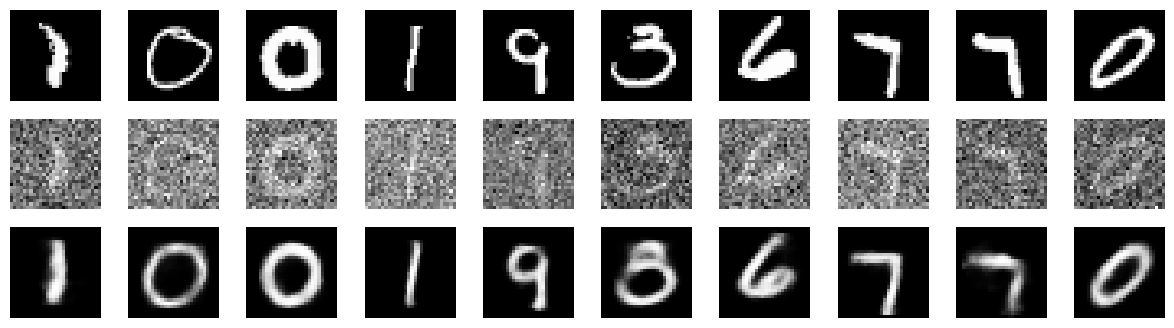

In [81]:
# sample some images and denoise
img, _, _ = next(iter(test_loader))
noisy_img = add_noise(img, 0.4)
denoised_img = model(noisy_img.view(-1, 28*28)).view(-1, 1, 28, 28)

fig, axs = plt.subplots(3, 10, figsize=(15, 4))
for i in range(10):
    axs[0, i].imshow(img[i].squeeze(), cmap='gray')
    axs[1, i].imshow(noisy_img[i].squeeze(), cmap='gray')
    axs[2, i].imshow(denoised_img[i].detach().numpy().squeeze(), cmap='gray')
    for j in range(3):
        axs[j, i].axis('off')

plt.show()

Considering, I can't really tell what any of those numbers are on the middle line, that's not terrible.

### Latent space visualization

In [82]:
encoder = model.encoder
decoder = model.decoder

In [97]:
# get the latent space of the test images and labels
latent_space = []
labels = []
for img, _, label in test_loader:
    img = img.view(-1, 28*28)
    latent_space.append(encoder(img).detach().numpy())
    label = np.argmax(label.numpy(), axis=1)
    labels.append(label)
latent_space = np.concatenate(latent_space)
labels = np.concatenate(labels)


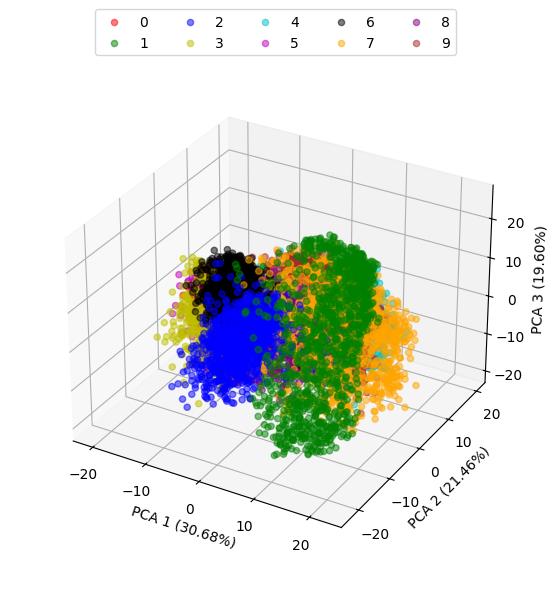

In [123]:
# pca
pca = PCA(n_components=3)
latent_pca = pca.fit_transform(latent_space)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'orange', 'purple', 'brown']
for i in range(10):
    ax.scatter(latent_pca[labels==i, 0], latent_pca[labels==i, 1], latent_pca[labels==i, 2], c=colors[i], label=i, alpha=0.5)
ax.set_xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
ax.set_ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
ax.set_zlabel(f"PCA 3 ({pca.explained_variance_ratio_[2]*100:.2f}%)")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5)
ax.set_box_aspect(None, zoom=0.9)
plt.tight_layout()
plt.show()

Let's try to "generate" some samples by drawing random numbers from the latent space.

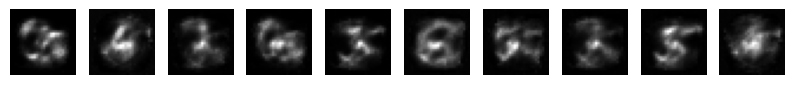

In [124]:
# sample some values from latent space
n = 10
x = torch.randn(n, 8)
x = decoder(x)

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(x[i].detach().numpy().reshape(28, 28), cmap='gray')
    axs[i].axis('off')

plt.show()

That looks pretty terrible, but you can sort of make out some digits...if you kind of squint.

# VAE
Let's first build the VAE. This is a bit more complicated than the autoencoder, but not by much. We still have the same number of layers and they are still just linear. The only difference is the forward pass. Since we are encoding our images into a mean and a variance, the final layer of the encoder is actually two layers, one for the mean and one for the variance, which we then split into two:
```python
mu, logvar = torch.chunk(h3, 2, dim=1)
```

We then have to use the reparameterization trick to sample from the latent space. This is done by sampling from a normal distribution and then scaling and shifting the samples by the mean and variance we just calculated:
```python
def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
```

We use the log variance because it makes our life slightly easier when we calculate the KL divergence.

In [127]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 16)
        # Decoder
        self.fc4 = nn.Linear(8, 32)
        self.fc5 = nn.Linear(32, 128)
        self.fc6 = nn.Linear(128, 784)

    def encode(self, x):
        h1 = nn.functional.gelu(self.fc1(x))
        h2 = nn.functional.gelu(self.fc2(h1))
        h3 = nn.functional.gelu(self.fc3(h2))

        mu, logvar = torch.chunk(h3, 2, dim=1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h4 = nn.functional.gelu(self.fc4(z))
        h5 = nn.functional.gelu(self.fc5(h4))
        return torch.sigmoid(self.fc6(h5))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Loss function
As discussed in the slides, we have two components to the loss function. The first is the reconstruction loss, which is just the mean squared error between the input and the output. The second is the KL divergence, which acts as a regularizer, forcing the latent space to be close to a normal distribution. We also have an additional hyperparamter $\beta$ which scales the KL divergence term. This is useful because the KL divergence term is not very useful at the start of training, but becomes more important as the model gets better.

In [128]:
def loss_function(recon_x, x, mu, logvar, beta):
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta*KLD

The training process is the same as before, except we have to return the reconstruction, mean and variance from the model in order to calculate the loss. And of course we are using our custom loss function.

In [140]:
BATCH_SIZE = 32

model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

train_loss = []
test_loss = []

for epoch in range(n_epochs):
    model.train()
    train_losses = []
    for img, _, _ in train_loader:
        # random noise factor between 0 and 1
        noise_factor = np.random.rand() * 0.5
        noisy_img = add_noise(img, noise_factor)
        img = img.view(-1, 28*28)
        noisy_img = noisy_img.view(-1, 28*28)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(noisy_img)
        loss = loss_function(recon_batch, img, mu, logvar, beta=0.1)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss.append(np.mean(train_losses))

    model.eval()
    test_losses = []
    for img, _, _ in test_loader:
        noise_factor = np.random.rand()
        noisy_img = add_noise(img, noise_factor)
        img = img.view(-1, 28*28)
        noisy_img = noisy_img.view(-1, 28*28)
        recon_batch, mu, logvar = model(noisy_img)
        loss = loss_function(recon_batch, img, mu, logvar, beta=0.1)
        test_losses.append(loss.item())
    test_loss.append(np.mean(test_losses))

    print(f'Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}')

Epoch 1, Train Loss: 1547.2451488932293, Test Loss: 1506.8442189762006
Epoch 2, Train Loss: 1185.184639420573, Test Loss: 1451.4830653766473
Epoch 3, Train Loss: 1105.8312452148436, Test Loss: 1421.3219077990839
Epoch 4, Train Loss: 1076.7601879882814, Test Loss: 1440.888671875
Epoch 5, Train Loss: 1063.8441948567709, Test Loss: 1441.5076419720635
Epoch 6, Train Loss: 1053.1476516927082, Test Loss: 1487.5653559773114
Epoch 7, Train Loss: 1046.3892915039062, Test Loss: 1465.8372675009048
Epoch 8, Train Loss: 1036.8881911132812, Test Loss: 1390.7111050054289
Epoch 9, Train Loss: 1032.5023485026043, Test Loss: 1410.592527736871
Epoch 10, Train Loss: 1026.2633759114583, Test Loss: 1431.3696310512555


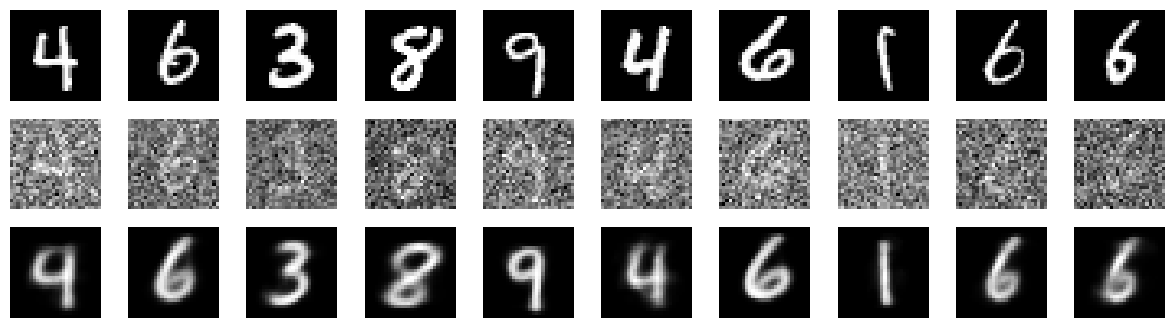

In [142]:
# sample some images and denoise
img, _, _ = next(iter(test_loader))
noisy_img = add_noise(img, 0.4)
denoised_img, _, _ = model(noisy_img.view(-1, 28*28))

fig, axs = plt.subplots(3, 10, figsize=(15, 4))
for i in range(10):
    axs[0, i].imshow(img[i].squeeze(), cmap='gray')
    axs[1, i].imshow(noisy_img[i].squeeze(), cmap='gray')
    axs[2, i].imshow(denoised_img[i].detach().numpy().squeeze().reshape((28,28)), cmap='gray')
    for j in range(3):
        axs[j, i].axis('off')

plt.show()

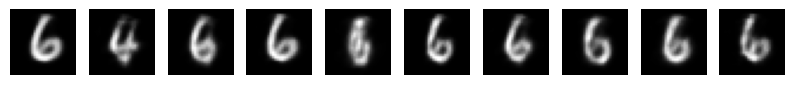

In [144]:
n = 10
x = torch.randn(n, 8)
x = model.decode(x)

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(x[i].detach().numpy().reshape(28, 28), cmap='gray')
    axs[i].axis('off')

plt.show()

There is not a whole lot of diversity here. So likely we will need to expand the range that we draw from in order to get more diverse samples.

In [159]:
# visualize latent space
latent_space = []
labels = []
for img, _, label in test_loader:
    img = img.view(-1, 28*28)
    latent_space.append(model.encode(img)[0].detach().numpy())
    label = np.argmax(label.numpy(), axis=1)
    labels.append(label)
latent_space = np.concatenate(latent_space)
labels = np.concatenate(labels)

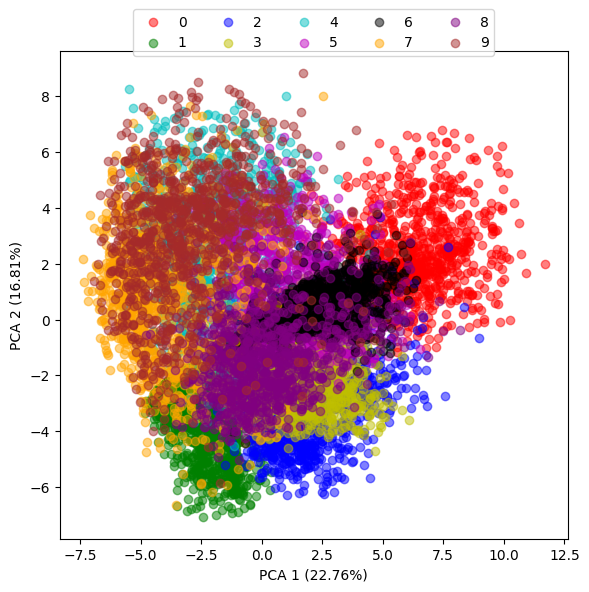

In [160]:
# pca
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_space)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'orange', 'purple', 'brown']
for i in range(10):
    ax.scatter(latent_pca[labels==i, 0], latent_pca[labels==i, 1], c=colors[i], label=i, alpha=0.5)
ax.set_xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
ax.set_ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5)

plt.tight_layout()
plt.show()

As we suspected, drawing from $N(0, 1)$ is not enough to get diverse samples. Let's try drawing from $N(0, 6)$ instead.

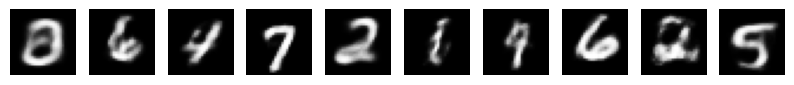

In [166]:
n = 10
# draw from N(0,6)
x = torch.randn(n, 8) * 6
x = model.decode(x)

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(x[i].detach().numpy().reshape(28, 28), cmap='gray')
    axs[i].axis('off')

plt.show()

Nice! We can see that the samples are much more diverse now. This is our first taste of generative models.

## Things to try:
1. Add convolutional layers to the VAE
2. Optimize the hyperparameters, particularly $\beta$
3. Try a different dataset like CIFAR-10
4. Try a bigger model and run it on a GPU